## 동전 인식 분류

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/kdt_231026/m8_vision

/content/drive/MyDrive/kdt_231026/m8_vision


In [3]:
from google.colab.patches import cv2_imshow

#### 오픈 연산 (cv2.MORPH_OPEN)
오픈 연산은 침식 연산(erode) 다음에 팽창 연산(dilate)을 수행하는 것으로 구성됩니다. 이 연산은 다음과 같은 효과를 가집니다:

- 작은 객체나 노이즈를 제거합니다.
- 두 객체 사이의 얇은 연결을 끊습니다.
- 객체의 경계를 부드럽게 합니다.

[ 연산 과정 ]
- 침식 연산: 커널이 위치한 모든 픽셀이 커널과 일치할 때만 원본 이미지의 중심 픽셀을 보존합니다. 이 과정에서 이미지의 작은 노이즈가 제거되고, 객체의 크기가 줄어듭니다.
- 팽창 연산: 커널과 하나라도 픽셀이 겹치는 경우, 원본 이미지의 중심 픽셀을 커널로 설정된 값으로 변경합니다. 침식에서 줄어든 객체의 크기가 다시 증가하면서, 노이즈는 제거된 상태를 유지합니다.

In [4]:
!pwd

/content/drive/MyDrive/kdt_231026/m8_vision


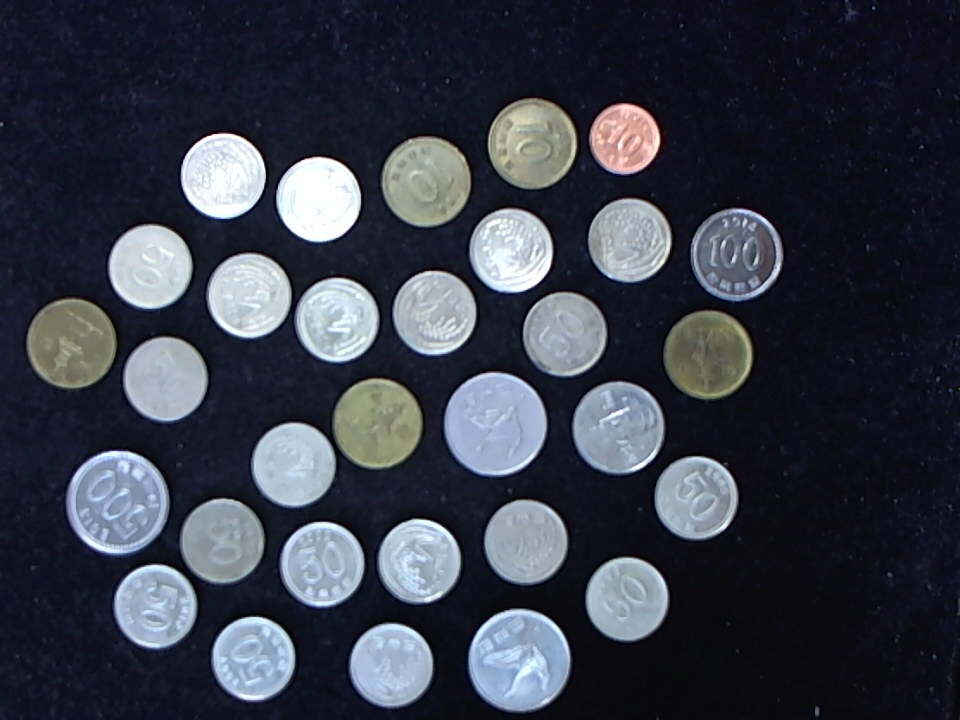

In [13]:
import numpy as np, cv2, time

fname = '/content/drive/MyDrive/kdt_231026/m8_vision/images/coin/65.png'
img = cv2.imread(fname)
cv2_imshow(img)

Preprocessed image:


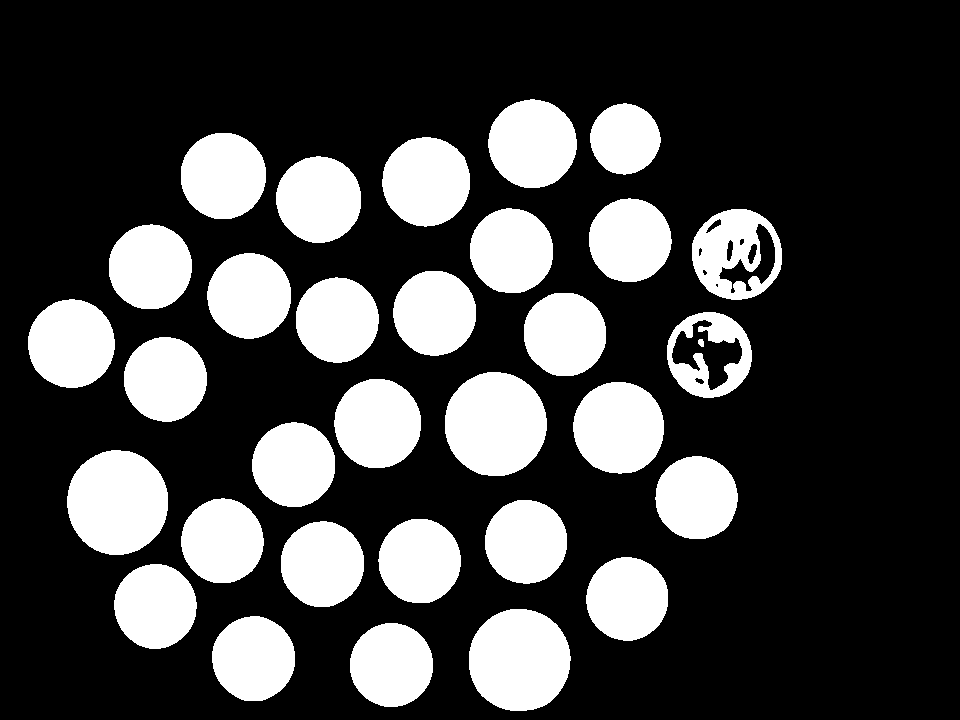

Coin image:


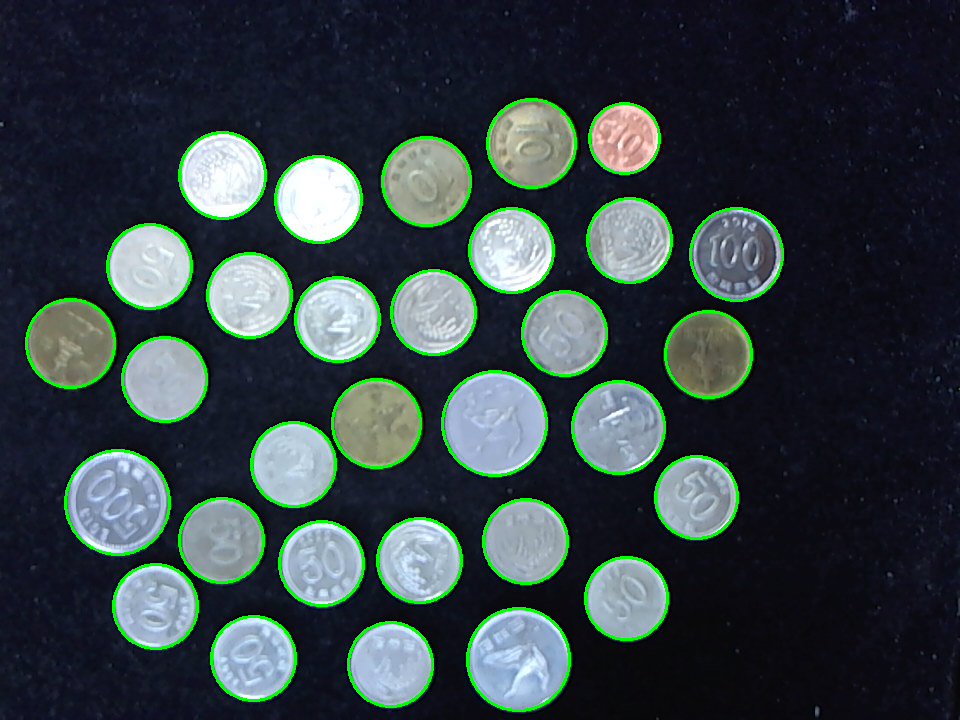

In [14]:
import numpy as np, cv2, time
import matplotlib.pyplot as plt

# 주어진 동전 영상 번호를 바탕으로 동전 영상을 읽고, 그레이스케일로 변환한 후 블러링과 이진화를 수행한 후 오픈 연산을 통해 작은 노이즈를 제거
def preprocessing(coin_no):                                # 전처리 함수
    fname = "images/coin/{0:02d}.png".format(coin_no)
    image = cv2.imread(fname, cv2.IMREAD_COLOR)             # 이미지 읽기
    if image is None: return None, None                     # None이 두 번 사용된 이유는 이 함수가 기본적으로 이미지 두 개(image와 th_img)를 반환하기 때문

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)          # 명암도 이미지 변환
    # 그레이스케일 이미지에 가우시안 블러를 적용, 이미지의 노이즈를 줄이고, 세부적인 정보를 감소시킴. 이진화 과정에서 배경과 동전을 더 잘 구분하기 위해 필요
    gray = cv2.GaussianBlur(gray, (7, 7), 2, 2)             #  X축과 Y축 방향으로 표준편차가 각각 2인 7x7 크기의 가우시안 커널을 사용하여 gray 이미지에 블러를 적용함을 의미
    # OTSU 알고리즘을 이용해 최적의 임계값을 자동으로 계산하고, 이를 기반으로 이진화를 수행
    flag = cv2.THRESH_BINARY + cv2.THRESH_OTSU              # OTSU 알고리즘은 전체 이미지의 히스토그램을 분석하여, 전경(동전)과 배경을 구분하는 최적의 임계값을 찾습니다.
    # OTSU 알고리즘을 사용하여 자동으로 계산된 최적의 임계값으로 gray 이미지를 이진화하여, 그 결과를 th_img에 저장
    _, th_img = cv2.threshold(gray, 130, 255, flag)         #  OTSU 알고리즘을 사용하여 최적의 임계값을 자동으로 계산하고, 그 값을 사용하여 이미지를 이진화
    # 3x3 크기의 구조 요소(커널)를 생성
    mask = np.ones((3, 3), np.uint8)
    # 이진화된 이미지에서 작은 노이즈나 객체를 제거하고, 떨어져 있는 객체를 더 명확하게 분리하는 등의 전처리를 수행
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask) # 열림 연산

    return image, th_img

image, th_img = preprocessing(65)                           # 전처리 수행
if image is None: raise Exception("이미지 파일 읽기 에러")

# 이미지에서 동전과 같은 원형 객체를 보다 효과적으로 검출하고, 노이즈로 인한 잘못된 검출을 최소화
def find_coins(image):
    # cv2.findContours 함수는 이미지에서 윤곽선을 찾는 데 사용.
    # cv2.RETR_EXTERNAL: 이 옵션은 이미지의 가장 바깥쪽 윤곽선만을 검출. 이는 각 동전의 외곽선만을 찾는 데 적합합니다.
    # cv2.CHAIN_APPROX_SIMPLE: 이 근사 방법은 윤곽선을 구성하는 점들 중 필요한 점들만을 반환하여 메모리를 절약. 예를 들어, 직사각형의 경우 4개의 모서리 점만을 반환.
    results = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4.x 이상에서 results[0]은 윤곽선 리스트, results[1]은 계층 정보
    # OpenCV 3.x에서 results[0]은 수정된 원본 이미지, results[1]은 윤곽선 리스트
    contours = results[0] if int(cv2.__version__[0]) >= 4 else results[1] # 윤곽선 리스트를 선택하기 위한 조건문

    # 리스트 생성 방식
    circles = [cv2.minEnclosingCircle(c) for c in contours] # 주어진 점들의 집합(여기서는 윤곽선 c)을 모두 포함하는 가장 작은 원을 찾습니다
    circles = [(tuple(map(int, center)), int(radius)) # 원의 중심 좌표와 반지름을 정수형으로 변환
               for center, radius in circles if radius>25] # 각 원의 반지름이 25 픽셀보다 큰 경우에만 해당 원을 새로운 리스트에 포함
    return circles

# 감지된 각 동전의 중심 좌표와 반지름 정보를 담고 있는 circles 리스트를 반환
circles = find_coins(th_img)
for center, radius in circles:
    # 각 동전의 중심(center), 반지름(radius)에 따라 원을 그립니다. 여기서 (0, 255, 0)은 녹색을 나타내며, 2는 원의 선 두께
    cv2.circle(image, center, radius, (0, 255, 0), 2)   # 동전 영상 원으로 표시

# 이미지 타이틀을 따로 처리하거나 제거합니다.
print("Preprocessed image:")
cv2_imshow(th_img)  # 첫 번째 인자만 전달
print("Coin image:")
cv2_imshow(image)  # 첫 번째 인자만 전달


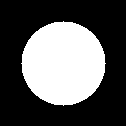

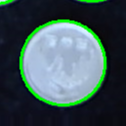

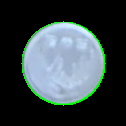

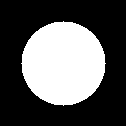

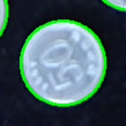

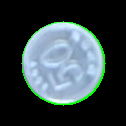

In [15]:
for center, radius  in circles[0:2]:
  r = radius * 3
  cen = (r // 2, r // 2)
  mask = np.zeros((r, r, 3), np.uint8)
  cv2.circle(mask, cen, radius, (255, 255, 255), cv2.FILLED)
  cv2_imshow(mask)
  print()
  coin = cv2.getRectSubPix(image, (r, r), center) # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
  cv2_imshow(coin)
  print()
  coin = cv2.bitwise_and(coin, mask)
  cv2_imshow(coin)
  print()


In [16]:
def make_coin_img(src, circles):
    coins = []
    for center, radius  in circles:
        r = radius * 3          # 검출 동전 반지름의 3 배. 동전을 추출하는 과정에서 동전 영상이 온전히 포함될 수 있도록 충분한 크기의 마스크를 생성
        cen = (r // 2, r // 2)  # 마스크 중심. 이미지의 가로와 세로 길이의 절반 위치가 정확히 이미지의 중앙
        mask = np.zeros((r, r, 3), np.uint8)                    # 마스크 행렬
        # 주어진 중심(cen), 반지름(radius), 색상((255, 255, 255), 그리고 채우기 옵션(cv2.FILLED)을 사용, 마스크 이미지 위에 흰색으로 채워진 원을 그립니다
        cv2.circle(mask, cen, radius, (255, 255, 255), cv2.FILLED)

        # 동전 영상 가져오기
        coin = cv2.getRectSubPix(src, (r, r), center) # 원본 이미지에서 동전이 위치한 사각형 영역이 추출
        # 마스크에서 흰색으로 표시된 부분(즉, 동전 영역)만이 결과 이미지에 남게 되고, 나머지 배경은 검은색(값이 0)으로 설정
        coin = cv2.bitwise_and(coin, mask)  # 마스킹 처리. coin 이미지와 mask 이미지 간의 비트 단위 AND 연산을 수행
        coins.append(coin)                                      # 동전 영상 저장
        # cv2_imshow("mask_" + str(center) , mask)                    # 마스크 영상 보기
    return coins

# 모든 막대를 검은색으로 그립니다.
def calc_histo_hue(coin):
    hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV)  # 컬러 공간 변환
    hsize, ranges = [32], [0, 180]         # 32개 막대, 화소값 0~180 범위
    hist = cv2.calcHist([hsv], [0], None, hsize, ranges) # 0은 HSV 이미지의 첫 번째 채널, 즉 색상(Hue) 채널을 의미, hsize: 각 차원별 빈(bin)의 개수
    return hist.flatten() #  다차원 배열의 모든 요소를 포함하는 새로운 1차원 배열을 생성

coin_no = 65
image, th_img = preprocessing(coin_no)                            # 전처리 수행
circles = find_coins(th_img)                     # 전처리된 이미지에서 동전을 검출
coin_imgs = make_coin_img(image, circles)        # 원본 이미지와 검출된 동전 정보를 바탕으로, 각 동전 영역만을 포함하는 이미지들을 생성
coin_hists = [calc_histo_hue(coin) for coin in coin_imgs] # 각 동전 이미지에 대해 HSV 색 공간에서 Hue(색상) 채널의 히스토그램을 계산

# 주어진 행의 수(rows)에 대응하는 HSV 색상 팔레트를 생성하고, 이를 BGR 색상 공간으로 변환하는 과정을 구현
def make_palate(rows):
    hue = [round(i * 180 / rows) for i in range(rows)]  # 전체 hue 범위를 rows의 수만큼 균일하게 나누어 각 hue 값을 계산. hue 값의 범위는 일반적으로 0에서 179까지
    hsv = [[(h, 255, 255)] for h in hue]                # 계산된 hue 값에 대해 채도(Saturation)와 명도(Value)를 최대값인 255로 설정하여 HSV 색상을 생성
    hsv = np.array(hsv, np.uint8)                       # numpy 행렬의 uint8형 변환
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)         # HSV 컬러 -> BGR 컬러

# 주어진 히스토그램 데이터를 바탕으로 색상 팔레트를 사용해 히스토그램 이미지를 생성하는 과정
# def draw_histo_hue(hist, shape=(200, 256,3)):
#     hsv_palate = make_palate(hist.shape[0])                      # 색상 팔레트 생성
#     hist_img = np.full(shape, 255, np.uint8)
#     cv2.normalize(hist, hist, 0, shape[0], cv2.NORM_MINMAX)    # 정규화
#     gap = hist_img.shape[1] / hist.shape[0]  # 한 계급 크기

#     for i, h in enumerate(hist):
#         x, w = int(round(i * gap)), int(round(gap))
#         if h > 0:
#             color = tuple(map(int, hsv_palate[i][0]))                    # 정수형 튜플로 변환
#             cv2.rectangle(hist_img, (x,0, w,int(h) ), color , cv2.FILLED) # 팔레트 색으로 그리기

#     return cv2.flip(hist_img, 0)





동전 이미지 번호: 65
 10원:   7개
 50원:  19개
100원:   2개
500원:   3개
Total coin: 2,720 Won
result image


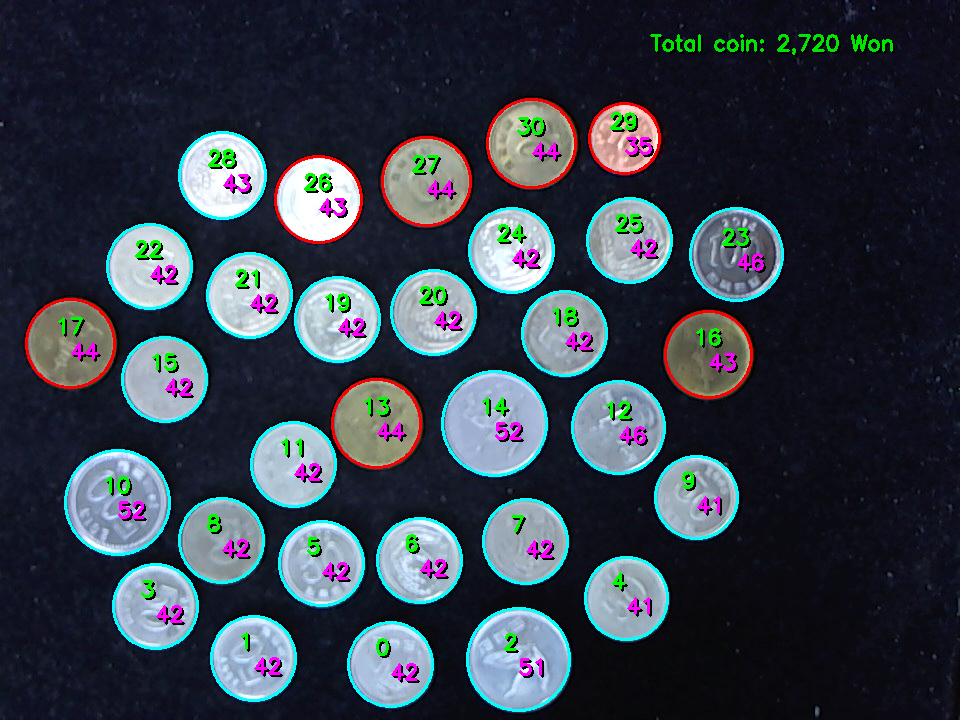

In [18]:
import numpy as np, cv2, time

coin_no = int(input("동전 이미지 번호: "))
image, th_img = preprocessing(coin_no)                              # 전처리 수행
circles = find_coins(th_img)                     # 객체(회전사각형) 검출
coin_imgs = make_coin_img(image, circles)                  # 동전 이미지 생성
coin_hists= [calc_histo_hue(coin) for coin in coin_imgs]   # 동전 이미지 히스토그램

def grouping(hists):
    # ws 리스트는 히스토그램의 각 빈(bin)에 적용될 가중치를 정의. 색상 분포의 특정 범위를 더 중요하게 다루고자 하는 의도를 반영
    # 중간 범위의 색상(즉, 리스트의 중간에 위치한 값들)이 더 중요하게 평가되어, 그 색상의 빈도가 높은 이미지가 특정 조건을 만족시키는 것으로 간주
    ws = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3,
          4, 5, 6, 8, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0]        # 가중치 지정

    sim = np.multiply(hists, ws) # 각 히스토그램에 가중치를 적용
    # 이 비율은 히스토그램이 가중치가 높은 색상을 얼마나 많이 포함하고 있는지를 나타내며 지표 특정 패턴이 얼마나 강조되는지를 의미
    similaritys = np.sum(sim, axis=1) / np.sum(hists, axis=1)
    # 계산된 유사도가 특정 임계값(여기서는 1.2)을 초과하는지 여부에 따라 히스토그램을 분류
    # 히스토그램의 유사도를 평가하는 기준점은 특정 문제나 데이터에 대한 사전 지식, 실험, 또는 경험적인 조정을 통해 정해집니다
    groups = [1 if s > 1.2 else 0 for s in similaritys]

    return groups

# 동전 인식 : 동전 종류 결정
def classify_coins(circles, groups):
    ncoins = [0] * 4 #  네 가지 종류의 동전을 카운트할 리스트를 초기화. [0] * 4는 [0, 0, 0, 0]과 동일
    g = np.full((2,70), -1, np.int32) # 배열의 크기는 2x70으로, 여기서 2는 그룹의 수를, 70은 반지름의 최대 가정된 값 범위,  모든 값을 -1로 초기화.
    # g[0, 26:47] = 0은 첫 번째 그룹(group = 0)에서 반지름이 26부터 46까지인 동전을 종류 0으로 분류
    g[0, 26:47], g[0, 47:50], g[0, 50:] = 0, 2, 3
    g[1, 36:44], g[1, 44:50], g[1, 50:] = 1, 2, 3
    # 해당 동전이 속한 그룹과 반지름을 기준으로 g 배열에서 동전의 종류(coin)를 찾습니다.
    for group, (_, radius) in zip(groups, circles):
        coin = g[group, radius]
        ncoins[coin] += 1

    return np.array(ncoins)

groups = grouping(coin_hists)                              # 동전 이미지 그룹 분리
ncoins = classify_coins(circles, groups)                   # 동전 인식

coin_value = np.array([10, 50, 100, 500])                             # 동전 금액
for i in range(4):
    print("%3d원: %3d개" % (coin_value[i], ncoins[i]))

# 문자열 출력 함수 - 그림자 효과
def put_string(frame, text, pt, value=None, color=(120, 200, 90)) :
    text = str(text) + str(value)
    shade = (pt[0] + 2, pt[1] + 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, text, shade, font, 0.7, (0, 0, 0), 2) # 그림자 효과
    cv2.putText(frame, text, pt   , font, 0.7, color, 2) # 작성 문자

total = sum(coin_value * ncoins )           # 동전금액* 동전별 개수
total_str = "Total coin: {:,} Won".format(total)            # 계산된 금액 문자열
print(total_str)                                                 # 콘솔창에 출력
put_string(image, total_str, (650, 50), '', (0,230,0))

## 동전 객체에 정보(인덱스, 반지름) 표시
color = [(0, 0, 250), (255, 255, 0), (0, 250, 0), (250, 0, 255)]  # 동전별 색상
for i, (c, r) in enumerate(circles):
    cv2.circle(image, c, r, color[groups[i]], 2)
    put_string(image, i, (c[0] - 15, c[1] - 10), '', color[2])  # 검출 순번과 동전 반지름 표시
    put_string(image, r, (c[0], c[1] + 15), '', color[3])

print("result image")
cv2_imshow(image)  # 첫 번째 인자만 전달